In [1]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)

my_colours = ["#4DAF4A", "#377EB8", "#984EA3", "#E41A1C", "#FF7F00"]

## Loading the data

In [2]:
# Load response matrices
rmf = fits.open("data/pspcc_gain1_256.rmf")
arf = fits.open("data/pspcc_gain1_256.arf")

cls_cov = sacc.Sacc.load_fits("data/cls_cov_y3.fits")

ROSAT, DESY3wl__0, cov__0 = cls_cov.get_ell_cl(
    "cl_0e", "ROSAT", "DESY3wl__0", return_cov=True)
err__0 = np.sqrt(np.diagonal(cov__0))

ROSAT, DESY3wl__1, cov__1 = cls_cov.get_ell_cl(
    "cl_0e", "ROSAT", "DESY3wl__1", return_cov=True)
err__1 = np.sqrt(np.diagonal(cov__1))

ROSAT, DESY3wl__2, cov__2 = cls_cov.get_ell_cl(
    "cl_0e", "ROSAT", "DESY3wl__2", return_cov=True)
err__2 = np.sqrt(np.diagonal(cov__2))

ROSAT, DESY3wl__3, cov__3 = cls_cov.get_ell_cl(
    "cl_0e", "ROSAT", "DESY3wl__3", return_cov=True)
err__3 = np.sqrt(np.diagonal(cov__3))

## Initialising defaults and tracers

In [3]:
# Set up cosmology and halo profiles
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)

dmat = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)
nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_def=mdef,
                             mass_function=nM,
                             halo_bias=bM,
                             log10M_max=15.0,
                             log10M_min=10,
                             nM=32)

# Redshift and number density
zs = cls_cov.tracers["DESY3wl__3"].z
nz = cls_cov.tracers["DESY3wl__3"].nz

# X-ray tracer
tx = rx.XrayTracer(cosmo)

# Weak lensing tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))

## Calculating the X-ray Spectrum

In [4]:
# Initialize ROSAT spectrum session
rosat = pyatomdb.spectrum.CIESession()
rosat.set_response(rmf, arf)

# Set the metallicity to 0.3 of the solar value
Zmetal = 0.3
Zs = np.ones(31)
Zs[3:] = Zmetal
rosat.set_abund(np.arange(31, dtype=int), Zs)

# Setting for X-ray parameters
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

# Load or calculate integrated X-ray spectra
if os.path.isfile("data/Jtot.pck"):
    with open("data/Jtot.pck", "rb") as f:
        J_tot = pickle.load(f)
else:
    J_tot = rosat.return_integrated_spectrum_interp(
        kTmin, kTmax, nkT, zmax, nz, emin, emax)
    with open("data/Jtot.pck", "wb") as f:
        pickle.dump(J_tot, f)

## Calculating the X-ray profile

In [5]:
a = 1.0
x = np.geomspace(0.001, 5, 128)
M = 1e14
r200 = mdef.get_radius(cosmo, M, a) / a
r = r200 * x

density_he = rx.HaloProfileDensityHE(
                mass_def=mdef, kind="n_total", concentration=cM)

pressure_he = rx.HaloProfilePressureHE(
                mass_def=mdef, kind="n_total", concentration=cM)

x_he = rx.HaloProfileXray(mass_def=mdef,
                          J=J_tot,
                          density=density_he,
                          pressure=pressure_he,
                          fourier_approx=False,
                          with_clumping=True)

## Calculating the $P(k)$s and $C_\ell$s

In [6]:
k_arr = np.geomspace(1e-4, 1e2, 256)
a_arr = np.linspace(0.3, 1, 8)
ls = np.unique(np.geomspace(2, 3100, 128).astype(int)).astype(float)

pk_he = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                               prof2=x_he, lk_arr=np.log(k_arr), a_arr=a_arr)
cl = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_he)
cl_he = rx.profiles.cl_smoothed(cl, ls)

## Plots

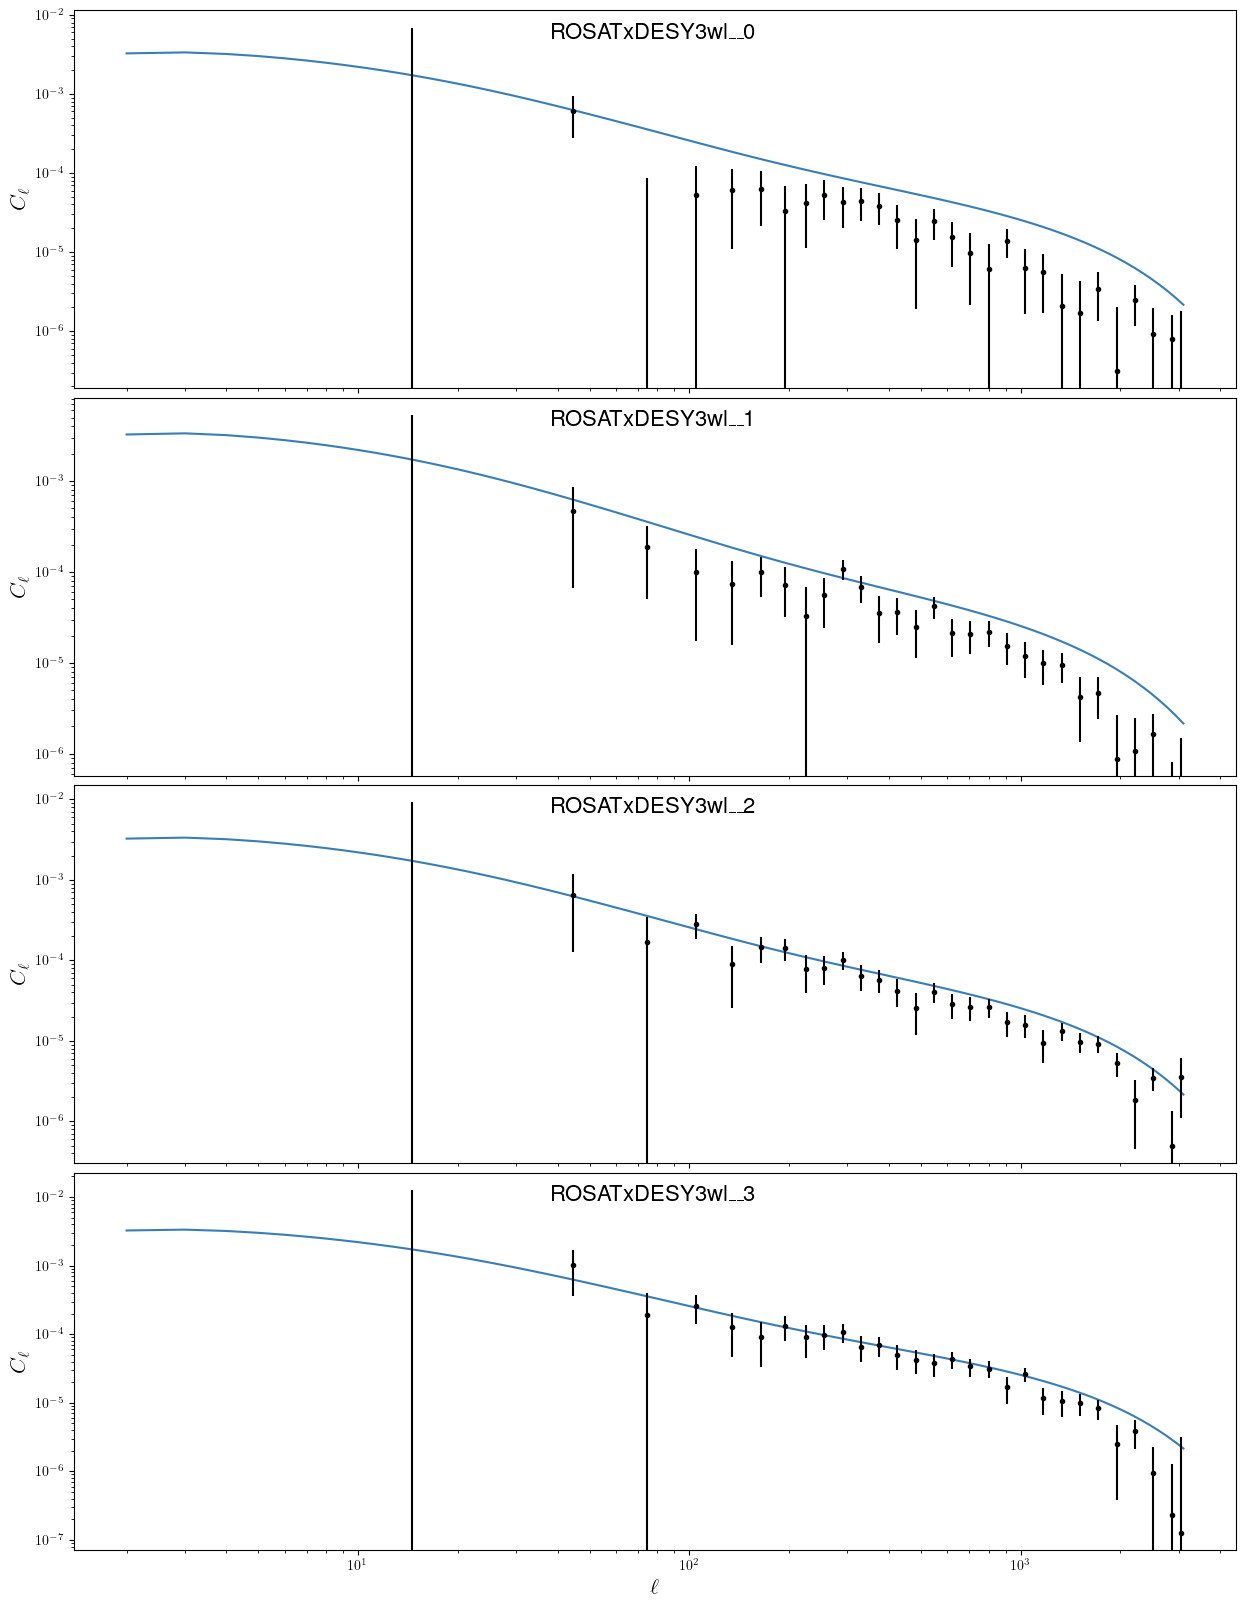

In [7]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20))
plt.subplots_adjust(hspace=0.025)

ax[0].plot(ls, cl_he, color=my_colours[1])
ax[0].errorbar(ROSAT, DESY3wl__0, yerr=err__0, fmt="k.")
ax[0].xaxis.set_tick_params(labelbottom=False)
ax[0].set_title(r"ROSATxDESY3wl__0", fontsize=16, y=1.0, pad=-20)

ax[1].plot(ls, cl_he, color=my_colours[1])
ax[1].errorbar(ROSAT, DESY3wl__1, yerr=err__1, fmt="k.")
ax[1].xaxis.set_tick_params(labelbottom=False)
ax[1].set_title(r"ROSATxDESY3wl__1", fontsize=16, y=1.0, pad=-20)

ax[2].plot(ls, cl_he, color=my_colours[1])
ax[2].errorbar(ROSAT, DESY3wl__2, yerr=err__2, fmt="k.")
ax[2].xaxis.set_tick_params(labelbottom=False)
ax[2].set_title(r"ROSATxDESY3wl__2", fontsize=16, y=1.0, pad=-20)

ax[3].plot(ls, cl_he, color=my_colours[1])
ax[3].errorbar(ROSAT, DESY3wl__3, yerr=err__3, fmt="k.")
ax[3].set_title(r"ROSATxDESY3wl__3", fontsize=16, y=1.0, pad=-20)

ax[0].loglog()
ax[1].loglog()
ax[2].loglog()
ax[3].loglog()

ax[0].set_ylabel(r"$C_\ell$", fontsize=16)
ax[1].set_ylabel(r"$C_\ell$", fontsize=16)
ax[2].set_ylabel(r"$C_\ell$", fontsize=16)
ax[3].set_ylabel(r"$C_\ell$", fontsize=16)

ax[3].set_xlabel(r"$\ell$", fontsize=16)

fig.savefig("Plots/HE_Cls.pdf")